In [2]:
# CARGA DE DATOS
from google.colab import files

# Carga de archivos
uploaded = files.upload()

Saving data_description.txt to data_description.txt
Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


Paso 1: Configuración Inicial y Carga de Datos

Importamos todas las librerías necesarias para el análisis de datos, preprocesamiento y modelado.

Cargamos los conjuntos de entrenamiento y prueba.

Guardamos las columnas 'Id' para el archivo de presentación final.

Eliminamos la columna 'Id' ya que no aporta información predictiva.

In [6]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Guardar IDs para la presentación final
train_ID = train['Id']
test_ID = test['Id']

# Eliminar columna ID ya que no es útil para la predicción
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

Paso 2: Análisis Exploratorio de Datos (EDA)

Visualizamos la distribución de SalePrice para entender su comportamiento y detectar outliers.

Creamos boxplots para identificar valores atípicos.

Analizamos variables categóricas importantes mediante gráficos de barras mostrando el precio mediano por categoría.

Examinamos variables numéricas importantes con histogramas y scatter plots contra SalePrice.

Generamos una matriz de correlación para entender relaciones entre variables.

Identificamos las 10 variables más correlacionadas con SalePrice

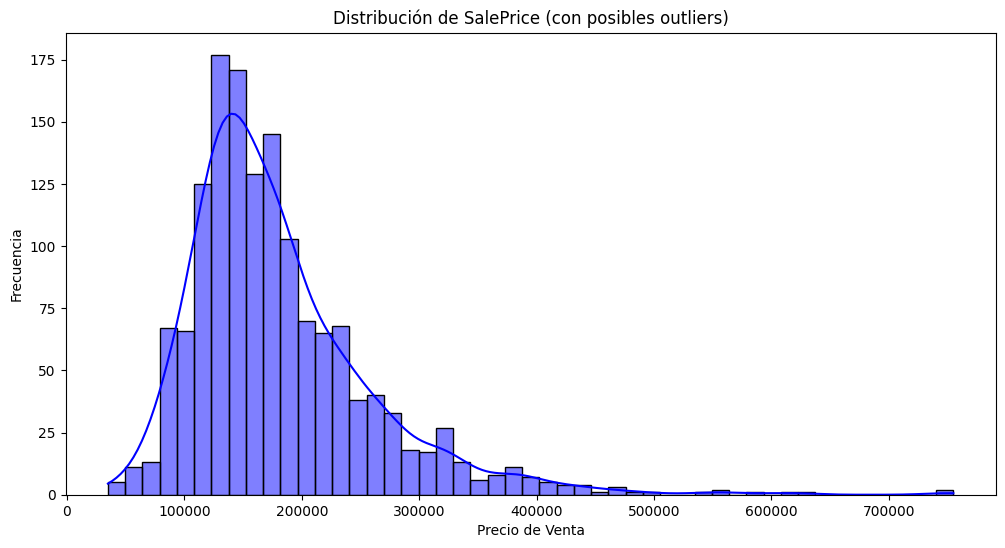

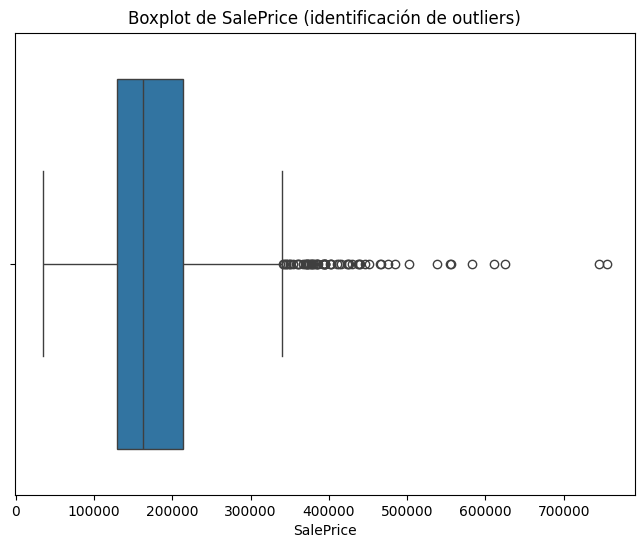

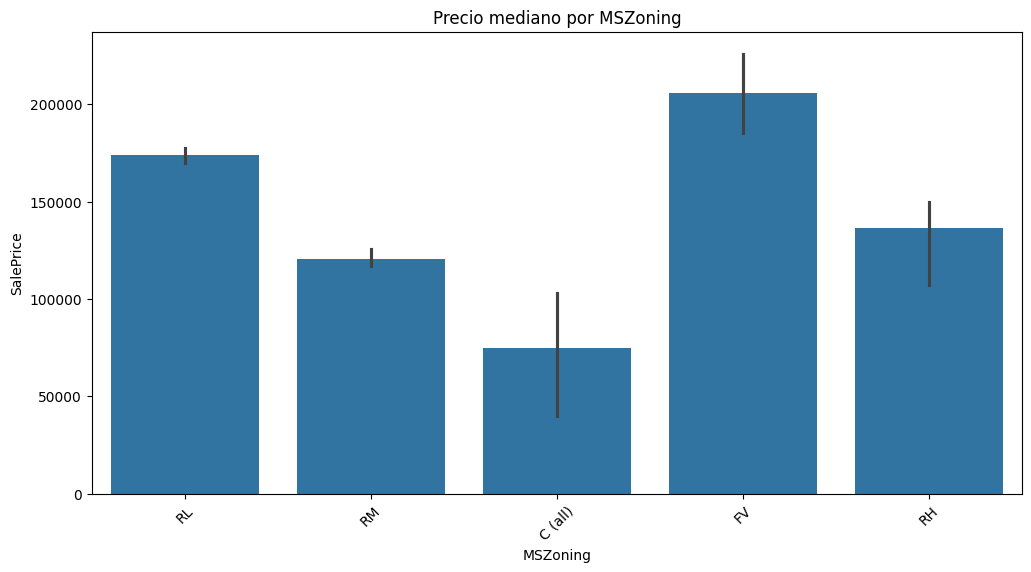

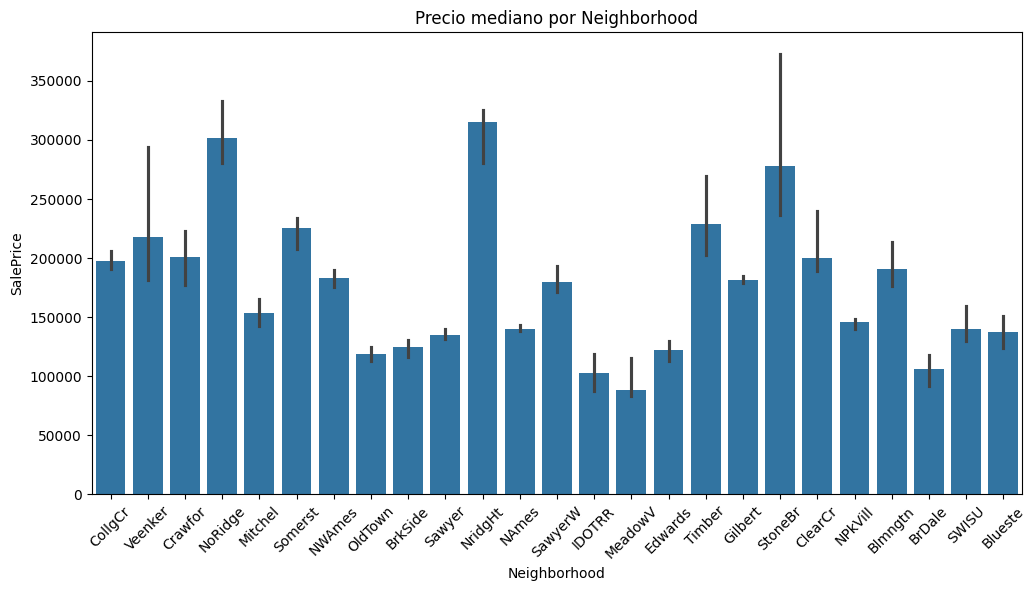

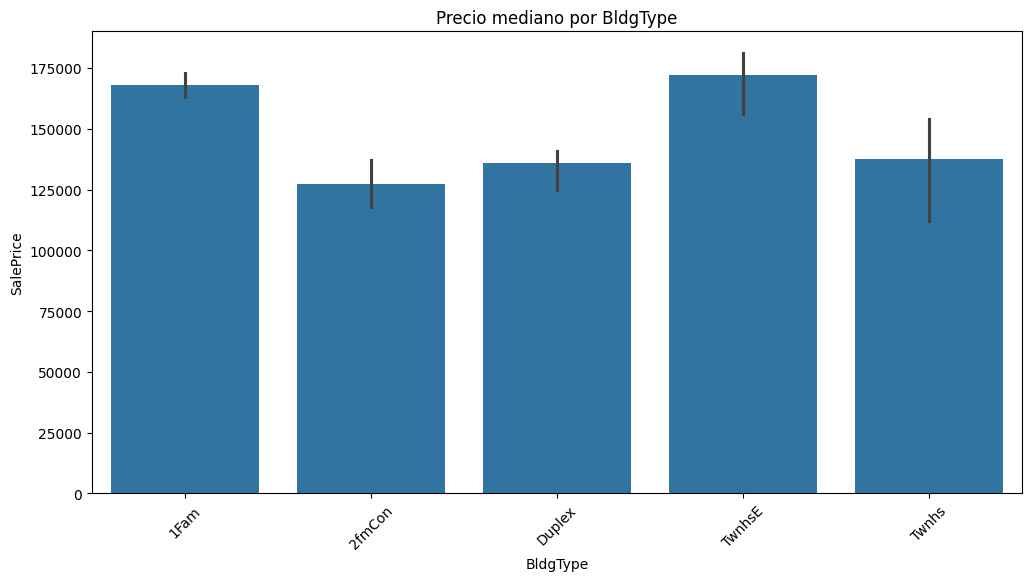

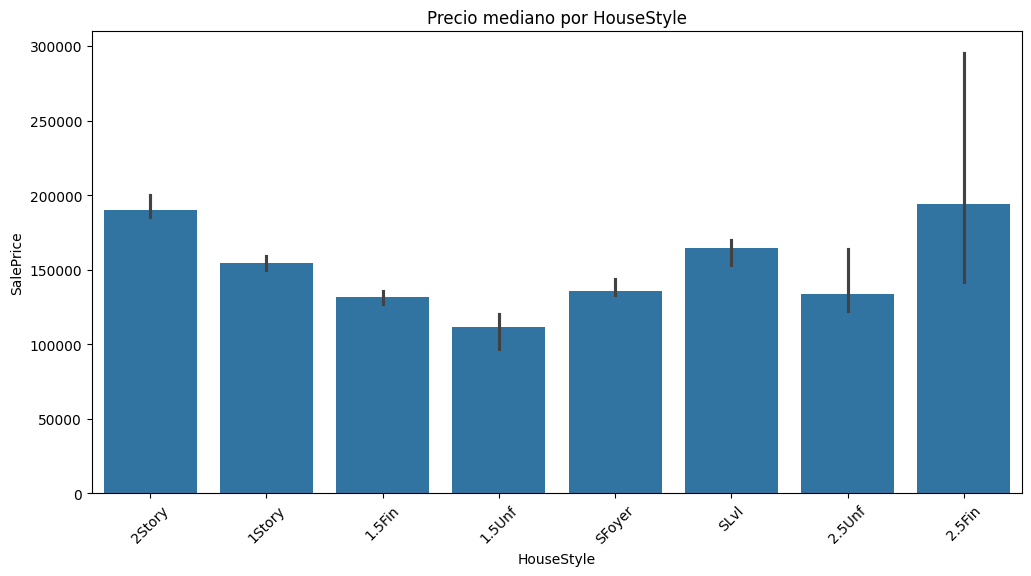

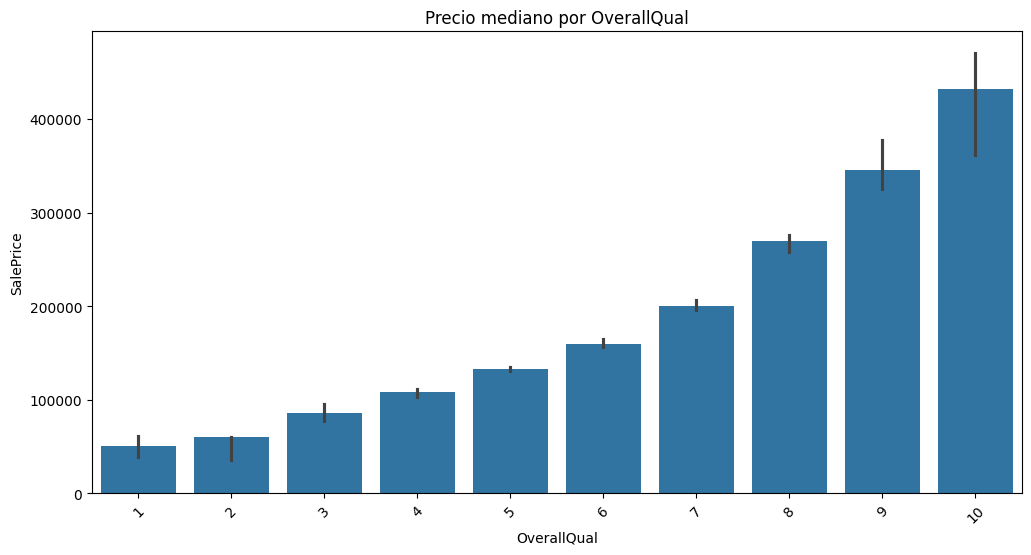

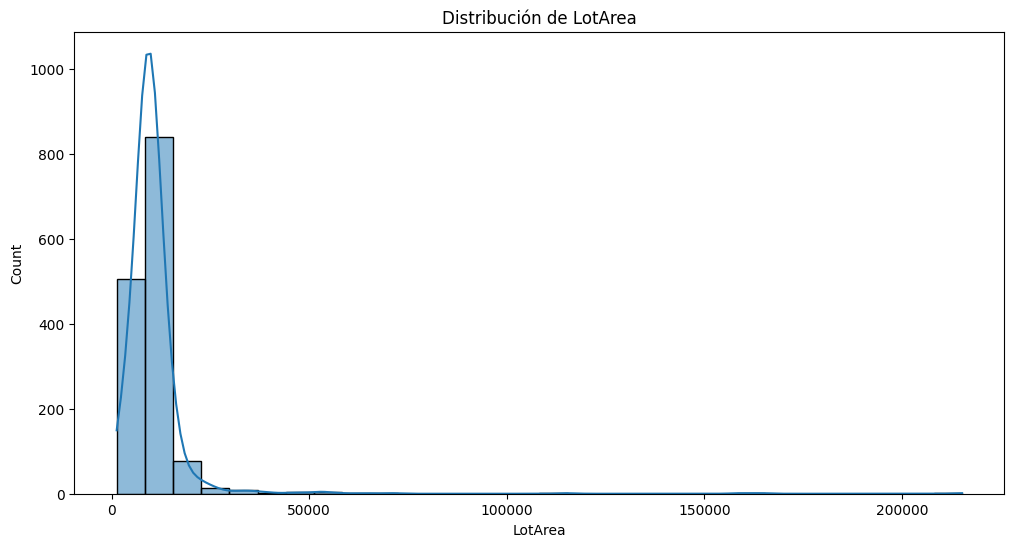

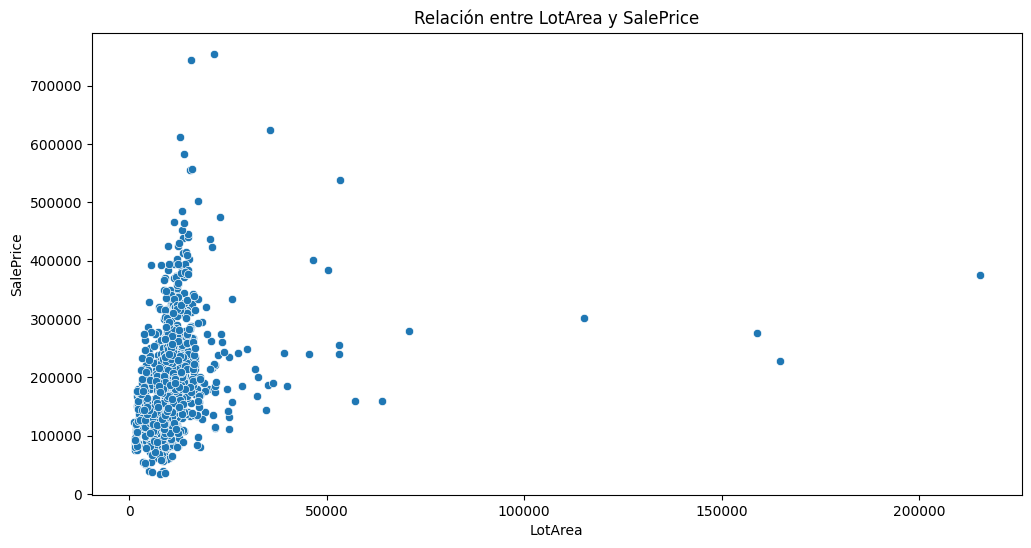

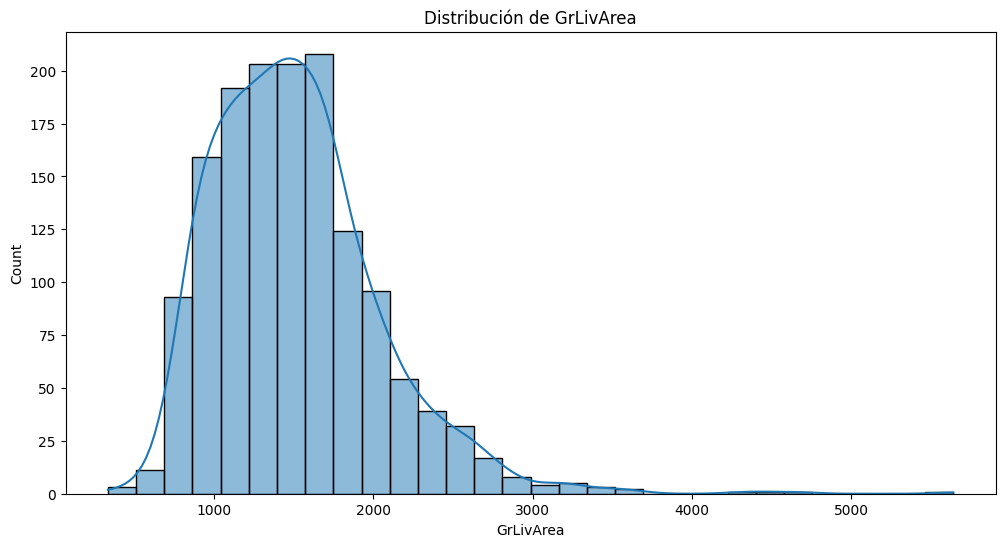

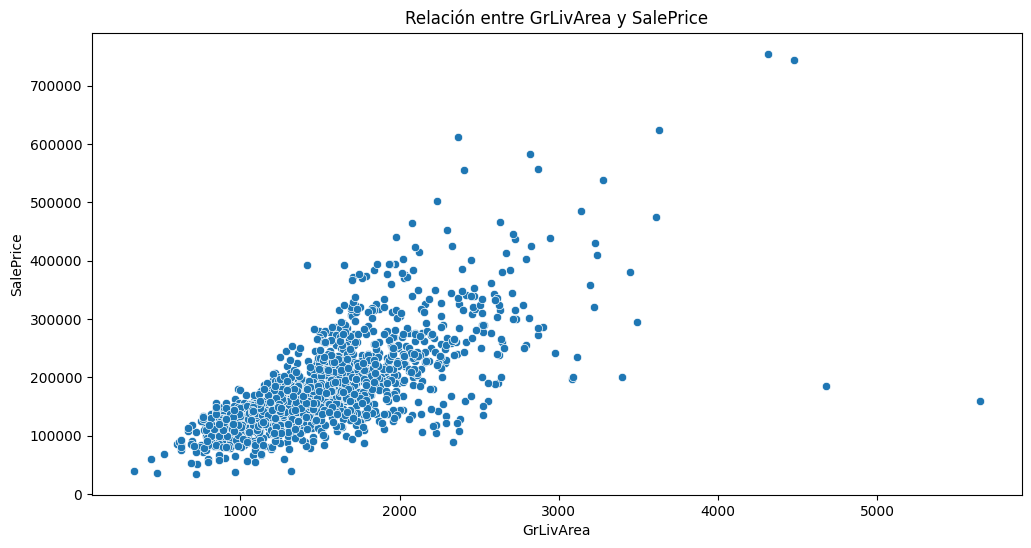

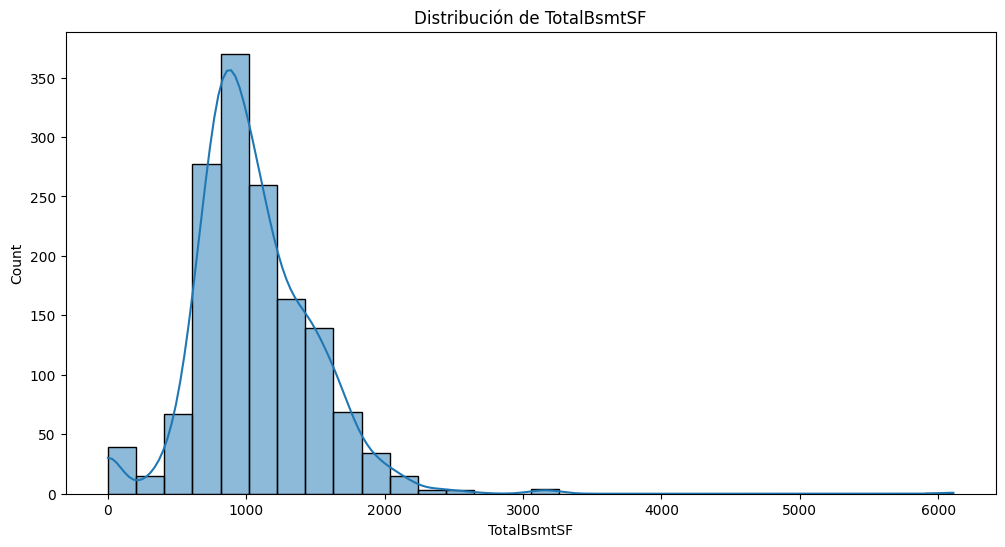

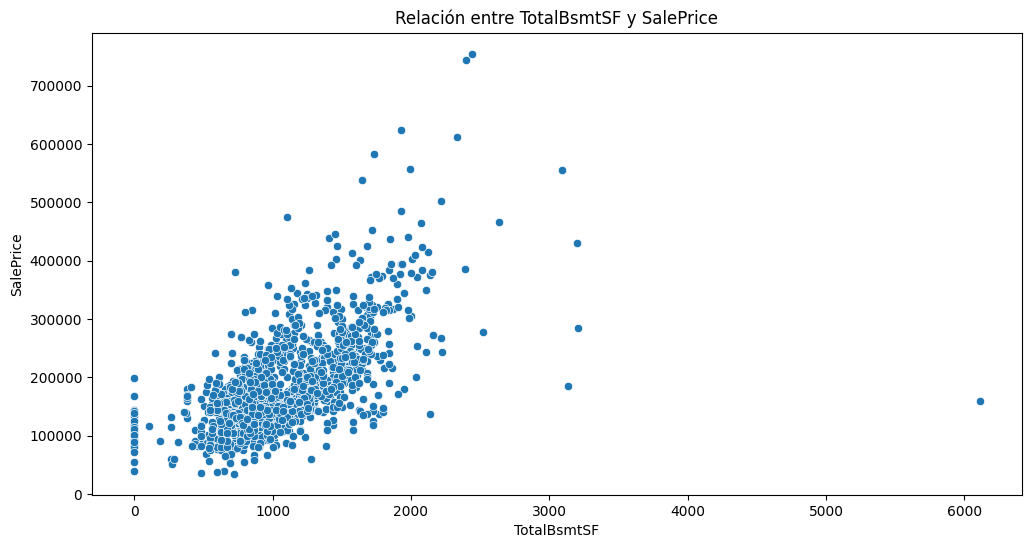

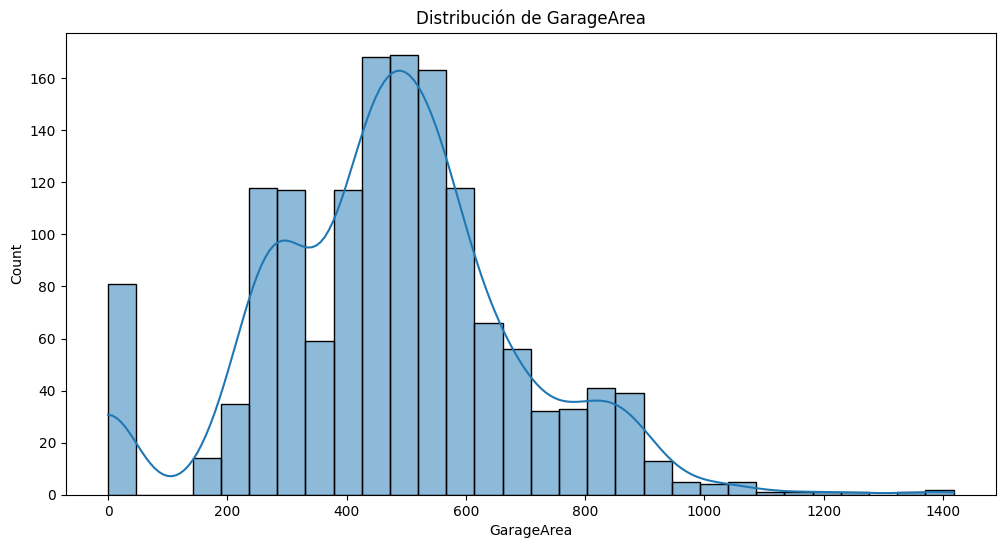

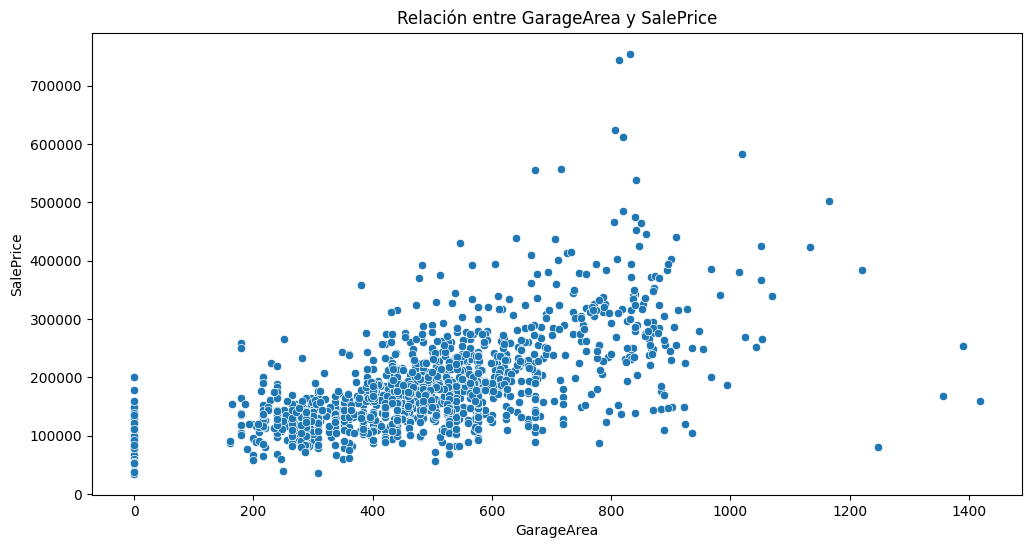

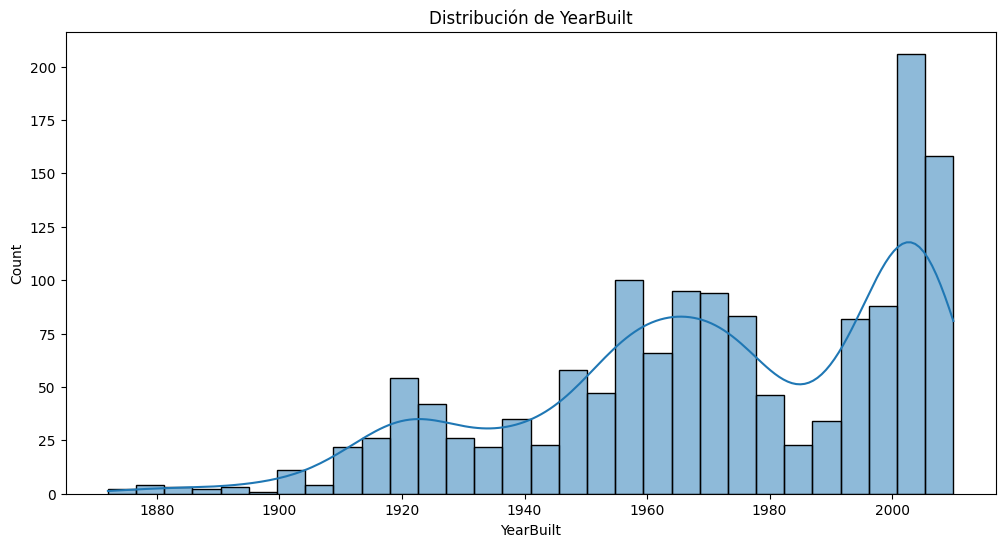

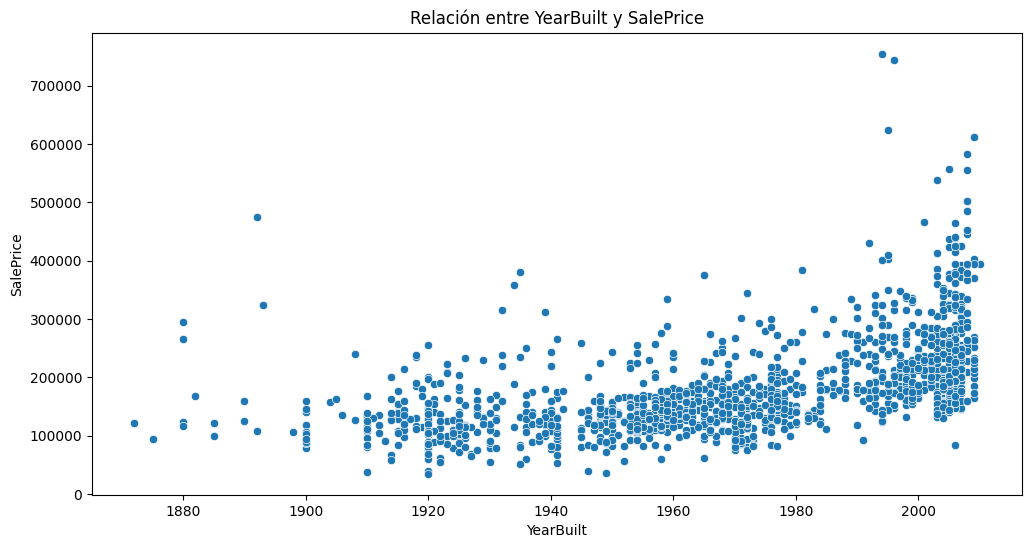

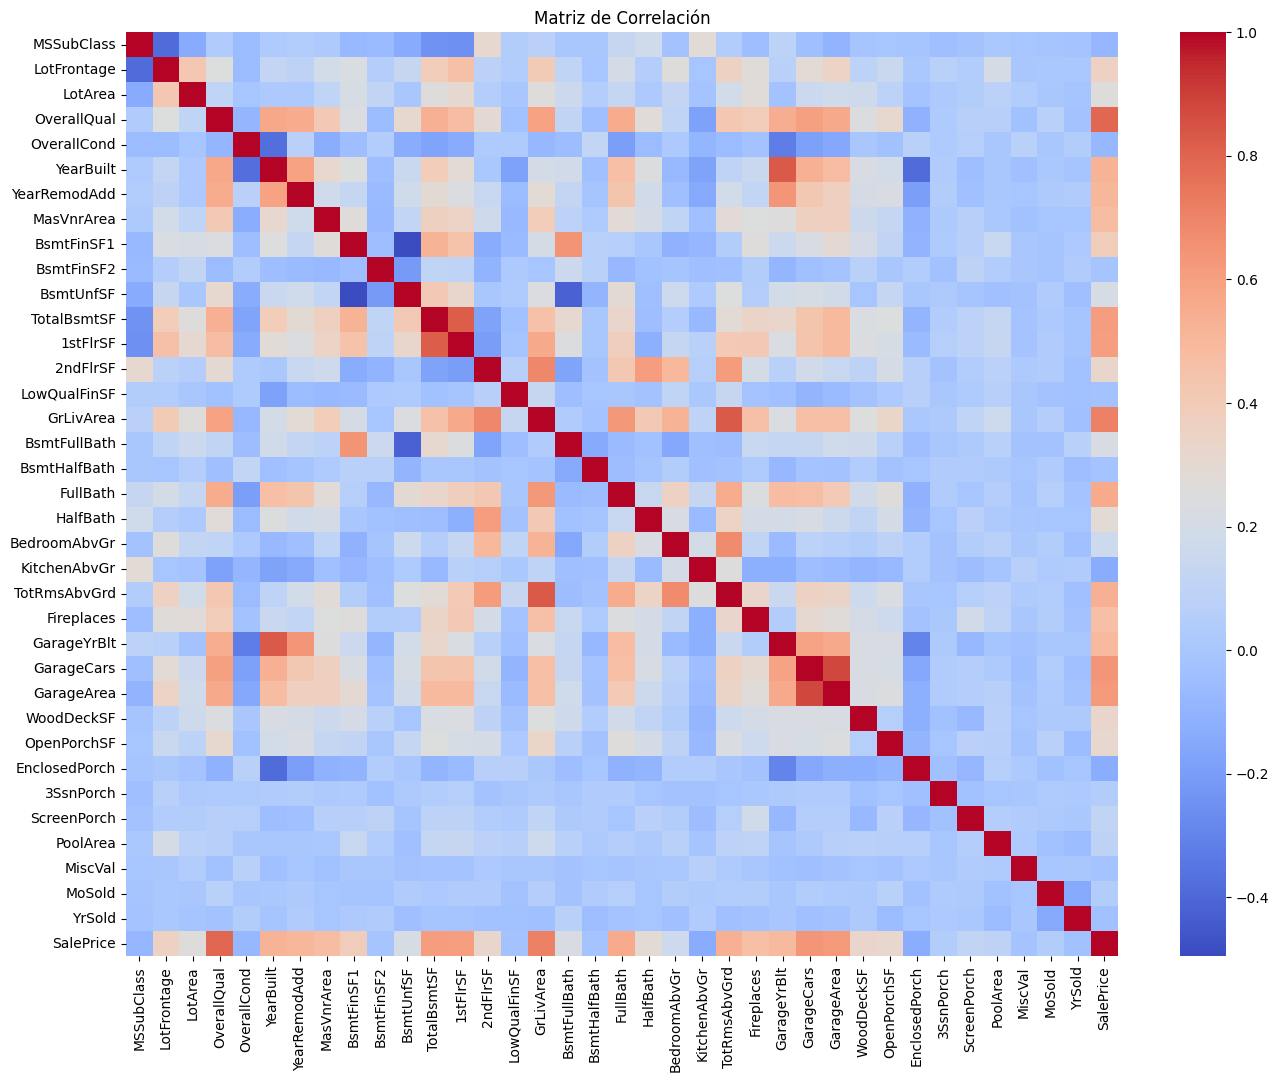

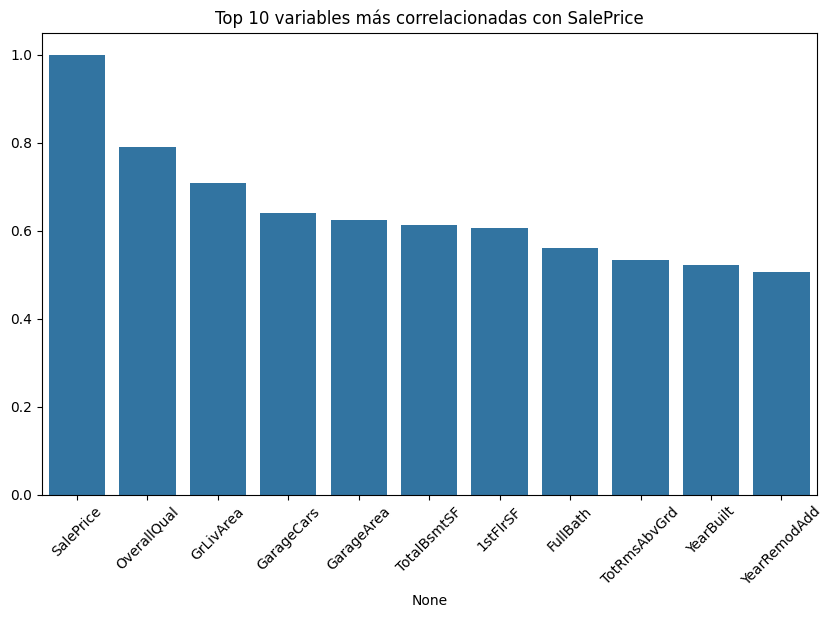

In [8]:
# 1. Distribución de la variable objetivo (SalePrice)
plt.figure(figsize=(12, 6))
sns.histplot(train['SalePrice'], kde=True, color='blue')
plt.title('Distribución de SalePrice (con posibles outliers)')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

# 2. Boxplot para identificar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['SalePrice'])
plt.title('Boxplot de SalePrice (identificación de outliers)')
plt.show()

# 3. Gráficos de barras para variables categóricas importantes
cat_cols = ['MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual']
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=train[col], y=train['SalePrice'], estimator=np.median)
    plt.title(f'Precio mediano por {col}')
    plt.xticks(rotation=45)
    plt.show()

# 4. Histogramas para variables numéricas importantes
num_cols = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']
for col in num_cols:
    plt.figure(figsize=(12, 6))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.show()

    # Scatter plot vs SalePrice
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=train[col], y=train['SalePrice'])
    plt.title(f'Relación entre {col} y SalePrice')
    plt.show()

# 5. Matriz de correlación
# Seleccionar solo columnas numéricas para la matriz de correlación
numeric_train = train.select_dtypes(include=np.number)
corr_matrix = numeric_train.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Top 10 variables más correlacionadas con SalePrice
# Asegurarse de que 'SalePrice' esté en las columnas numéricas seleccionadas
if 'SalePrice' in numeric_train.columns:
    top_corr = corr_matrix['SalePrice'].sort_values(ascending=False).head(11)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_corr.index, y=top_corr.values)
    plt.title('Top 10 variables más correlacionadas con SalePrice')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("'SalePrice' no encontrada en las columnas numéricas para calcular las principales correlaciones.")

Paso 3: Preprocesamiento de Datos

Guardamos la variable objetivo (SalePrice) antes de combinar los datasets.

Visualizamos la distribución original de SalePrice y aplicamos una transformación logarítmica para normalizarla.

Combinamos los datos de entrenamiento y prueba para aplicar consistentemente el preprocesamiento

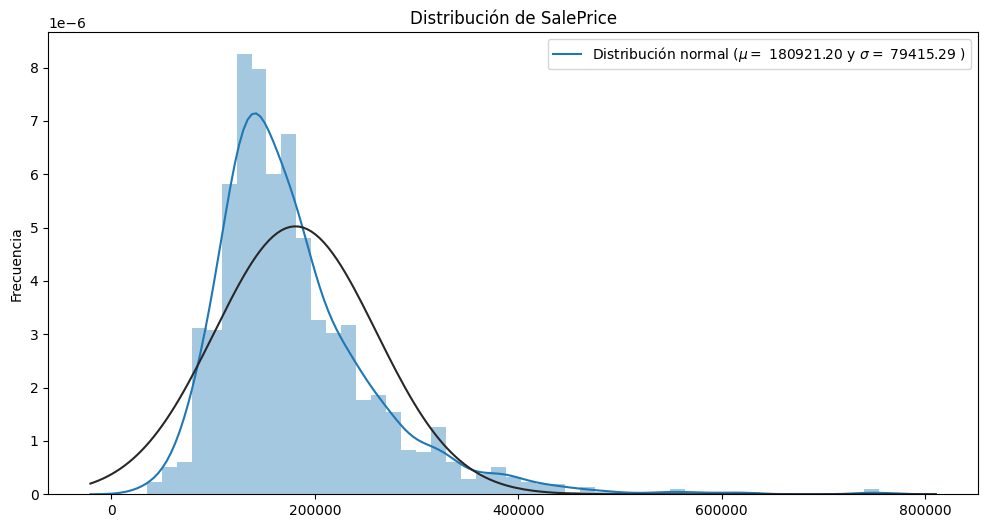

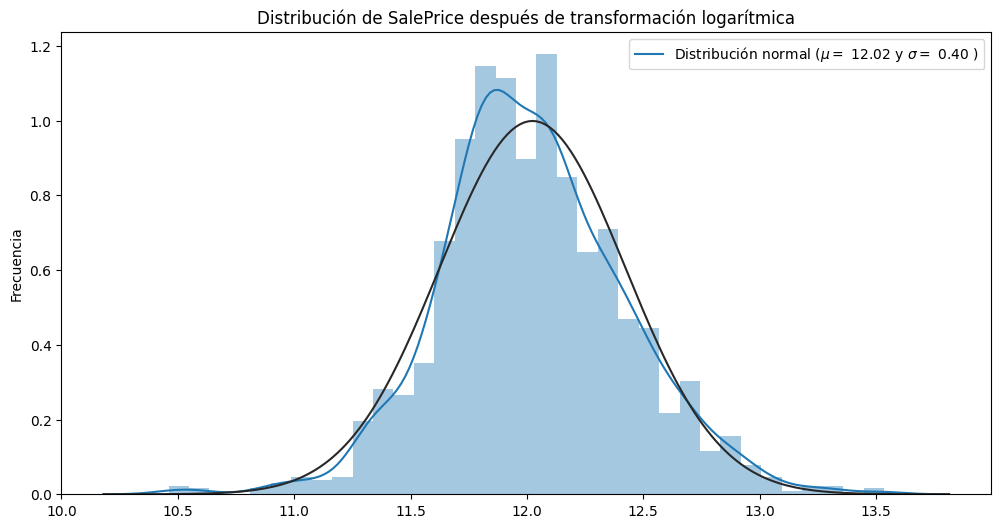

In [10]:
# Guardar la variable objetivo antes de combinar los datasets
y_train = train['SalePrice'].values

# Explorar SalePrice (variable objetivo)
plt.figure(figsize=(12, 6))
sns.distplot(y_train, fit=norm)
plt.ylabel('Frecuencia')
plt.title('Distribución de SalePrice')
(mu, sigma) = norm.fit(y_train)
plt.legend([f'Distribución normal ($\mu=$ {mu:.2f} y $\sigma=$ {sigma:.2f} )'], loc='best')
plt.show()

# Transformación logarítmica de SalePrice para normalizar
y_train = np.log1p(y_train)

# Visualizar distribución después de la transformación
plt.figure(figsize=(12, 6))
sns.distplot(y_train, fit=norm)
plt.ylabel('Frecuencia')
plt.title('Distribución de SalePrice después de transformación logarítmica')
(mu, sigma) = norm.fit(y_train)
plt.legend([f'Distribución normal ($\mu=$ {mu:.2f} y $\sigma=$ {sigma:.2f} )'], loc='best')
plt.show()

# Combinar train y test para la ingeniería de características
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train.drop(['SalePrice'], axis=1), test)).reset_index(drop=True)

Paso 4: Manejo de Datos Faltantes

Analizamos y visualizamos el porcentaje de valores faltantes por variable.

Rellenamos los valores faltantes según el significado de cada variable (None para ausencia, mediana para valores continuos, moda para categóricas).

Verificamos que no queden valores faltantes.

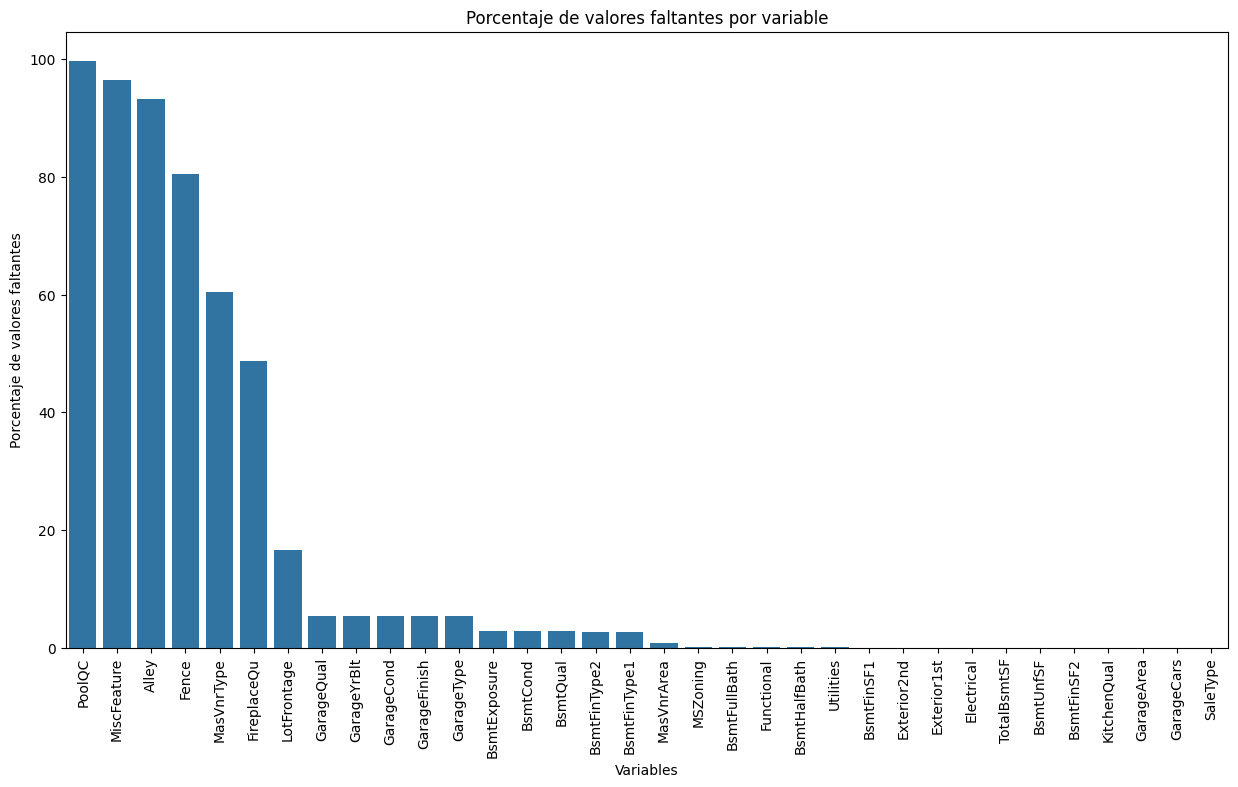

Valores faltantes restantes: Series([], dtype: float64)


In [11]:
# Analizar datos faltantes
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

# Visualizar datos faltantes
plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.index, y=missing_data['Missing Ratio'])
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Porcentaje de valores faltantes')
plt.title('Porcentaje de valores faltantes por variable')
plt.show()

# Rellenar valores faltantes (como en tu código original)
# PoolQC: NA significa sin alberca
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
# MiscFeature: NA significa sin características misceláneas
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
# Alley: NA significa sin acceso por callejón
all_data["Alley"] = all_data["Alley"].fillna("None")
# Fence: NA significa sin cerca
all_data["Fence"] = all_data["Fence"].fillna("None")
# FireplaceQu: NA significa sin chimenea
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
# LotFrontage: Rellenar con la mediana del vecindario
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
# Características del garaje
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
# Características del sótano
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
# Revestimiento de mampostería
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# MSZoning: Rellenar con el valor más común
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# Utilities: Casi todos son "AllPub", así que se elimina la columna
all_data = all_data.drop(['Utilities'], axis=1)
# Functional: Rellenar con valor típico
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# Electrical: Rellenar con el valor más común
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# KitchenQual: Rellenar con el valor más común
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
# Exterior1st y Exterior2nd: Rellenar con el valor más común
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
# SaleType: Rellenar con el valor más común
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
# MSSubClass: Rellenar con el valor más común
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

# Verificar si aún hay valores faltantes
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
print("Valores faltantes restantes:", all_data_na)

Paso 5: Ingeniería de Características

Creamos nuevas características combinando existentes (superficie total, baños totales, etc.).

Convertimos variables numéricas que realmente son categóricas (como códigos de clasificación).

Codificamos variables categóricas usando LabelEncoder para ordinales y get_dummies para nominales.

Dividimos los datos nuevamente en conjuntos de entrenamiento y prueba.

In [12]:
# Agregar características nuevas
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['Remodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)
all_data['IsNew'] = (all_data['YrSold'] == all_data['YearBuilt']).astype(int)

# Agrupar vecindarios según el precio mediano
neighborhood_map = train.groupby('Neighborhood')['SalePrice'].median().sort_values().index
neighborhood_dict = {k: v for v, k in enumerate(neighborhood_map, 1)}
all_data['NeighborhoodBinned'] = all_data['Neighborhood'].map(neighborhood_dict)

# Convertir algunas variables numéricas que en realidad son categóricas
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Codificar variables categóricas
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# Obtener variables dummy para las variables categóricas restantes
all_data = pd.get_dummies(all_data)

# Dividir los datos nuevamente en train y test
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

Paso 6: Manejo de Outliers y Transformación de Variables

Identificamos y eliminamos outliers visualmente en el gráfico de GrLivArea vs SalePrice.

Analizamos la asimetría de las variables numéricas y aplicamos transformación Box-Cox a las más sesgadas.

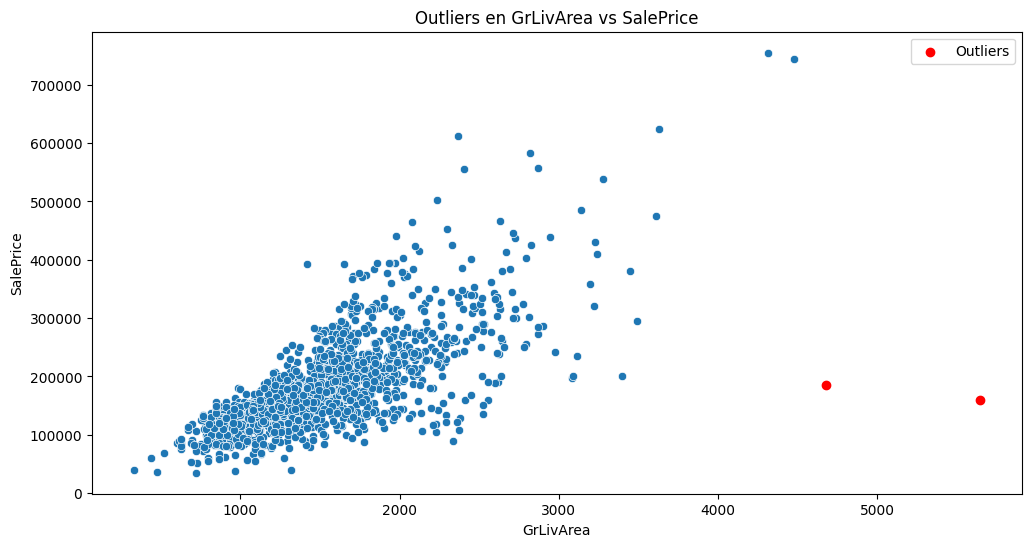

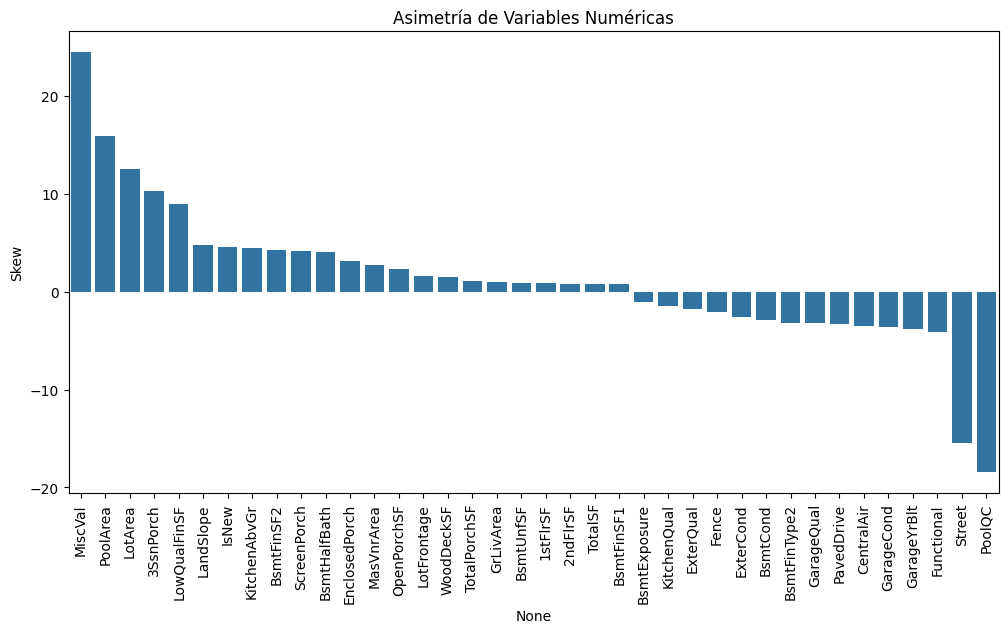

In [13]:
# Eliminar outliers (usando los valores originales de SalePrice antes de log)
train_original = pd.read_csv('train.csv')
outliers = train_original[(train_original['GrLivArea']>4000) & (train_original['SalePrice']<300000)].index
X_train = X_train.drop(outliers)
y_train = np.delete(y_train, outliers)

# Visualizar outliers en GrLivArea vs SalePrice
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train_original['GrLivArea'], y=train_original['SalePrice'])
plt.scatter(x=train_original.loc[outliers, 'GrLivArea'],
            y=train_original.loc[outliers, 'SalePrice'],
            color='red', label='Outliers')
plt.title('Outliers en GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

# Verificar la asimetría de características numéricas
numeric_feats = all_data.dtypes[(all_data.dtypes != "object") & (all_data.dtypes != "bool")].index
skewed_feats = X_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness['Skew']) > 0.75]

# Visualizar asimetría
plt.figure(figsize=(12, 6))
sns.barplot(x=skewness.index, y=skewness['Skew'])
plt.xticks(rotation=90)
plt.title('Asimetría de Variables Numéricas')
plt.show()

# Aplicar transformación de Box-Cox a las características con alta asimetría
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if X_train[feat].nunique() > 1:
        X_train[feat] = boxcox1p(X_train[feat], lam)
        X_test[feat] = boxcox1p(X_test[feat], lam)

Paso 7: Modelado y Evaluación

Función rmse_cv: Evalúa modelos con validación cruzada (5 folds), retornando RMSE promedio ± desviación estándar.

Modelos configurados: 5 algoritmos (Lasso, ElasticNet, Kernel Ridge, Gradient Boosting, XGBoost) con hiperparámetros optimizados.

Evaluación automática: Bucle que prueba cada modelo, guarda resultados y los imprime formateados.

Visualización clara: Gráfico de barras ordenado por RMSE (más bajo = mejor), con barras de error y valores numéricos.

Objetivo: Identificar el modelo más preciso y consistente para predecir precios de casas (o cualquier problema de regresión).

Lasso: 0.1103 ± 0.0066
ElasticNet: 0.1102 ± 0.0066
Kernel Ridge: 0.1786 ± 0.0050
Gradient Boosting: 0.1148 ± 0.0076
XGBoost: 0.1147 ± 0.0052


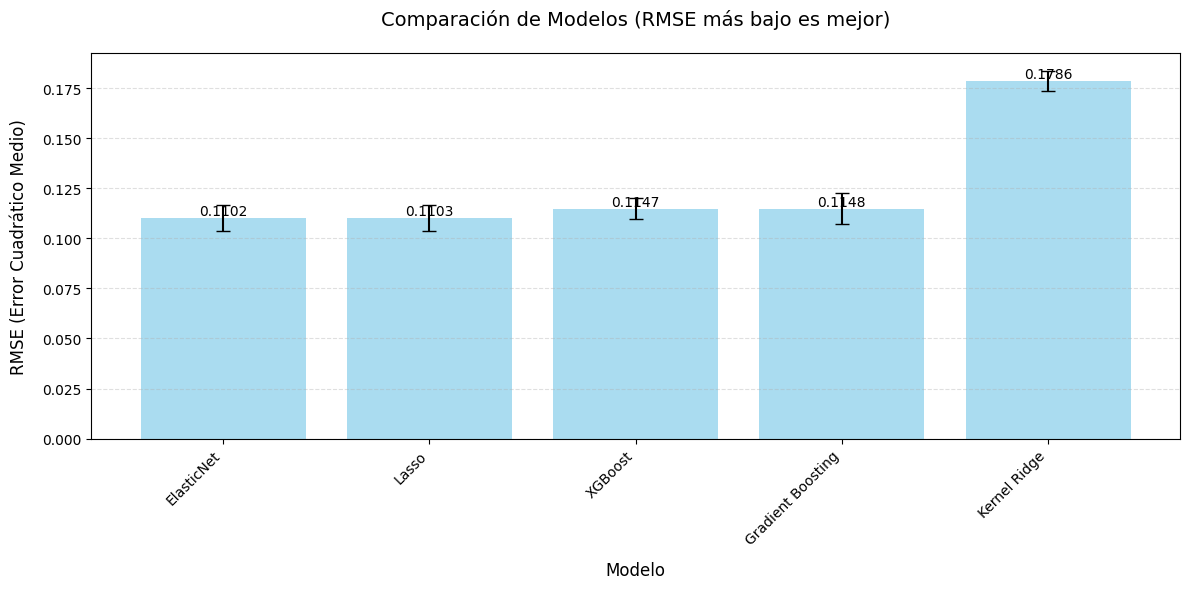

In [20]:
# 1. Definición de la función de evaluación
def rmse_cv(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean(), rmse.std()  # Retornamos media y std directamente

# 2. Configuración de modelos
models = {
    'Lasso': Lasso(alpha=0.0005, random_state=1),
    'ElasticNet': ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3),
    'Kernel Ridge': KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=3000, learning_rate=0.05,
        max_depth=4, max_features='sqrt',
        min_samples_leaf=15, min_samples_split=10,
        loss='huber', random_state=5),
    'XGBoost': XGBRegressor(
        colsample_bytree=0.4603, gamma=0.0468,
        learning_rate=0.05, max_depth=3,
        min_child_weight=1.7817, n_estimators=2200,
        reg_alpha=0.4640, reg_lambda=0.8571,
        subsample=0.5213, random_state=7, nthread=-1)
}

# 3. Evaluación de modelos
results = []
for name, model in models.items():
    mean_score, std_score = rmse_cv(model, X_train, y_train)
    results.append([name, mean_score, std_score])
    print(f"{name}: {mean_score:.4f} ± {std_score:.4f}")

# 4. Preparación de datos para visualización
results_df = pd.DataFrame(results, columns=['Modelo', 'RMSE Mean', 'RMSE Std'])
results_df = results_df.sort_values('RMSE Mean')

# 5. Visualización


plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Modelo'], results_df['RMSE Mean'],
               yerr=results_df['RMSE Std'], capsize=5, color='skyblue', alpha=0.7)


plt.title('Comparación de Modelos (RMSE más bajo es mejor)', pad=20, fontsize=14)
plt.xlabel('Modelo', fontsize=12, labelpad=10)
plt.ylabel('RMSE (Error Cuadrático Medio)', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Paso 8: Ensamblaje de Modelos y Predicción Final

Creamos un ensamblaje de modelos promediando las predicciones.

Entrenamos modelos individuales para una combinación ponderada final.

Combinamos las predicciones con pesos optimizados para mejorar el rendimiento

In [21]:
# Stacking modelo
class AveragingModels():
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models
        ])
        return np.mean(predictions, axis=1)

# Promediar los mejores modelos
averaged_models = AveragingModels(models=(ENet, GBoost, model_xgb))
averaged_models.fit(X_train.values, y_train)
stacked_train_pred = averaged_models.predict(X_train.values)
stacked_pred = averaged_models.predict(X_test.values)

# Entrenar modelos individuales para el ensamblaje
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = model_xgb.predict(X_test)

lasso.fit(X_train, y_train)
lasso_train_pred = lasso.predict(X_train)
lasso_pred = lasso.predict(X_test)

GBoost.fit(X_train, y_train)
gboost_train_pred = GBoost.predict(X_train)
gboost_pred = GBoost.predict(X_test)

# Ensemble predictions (combinación ponderada)
ensemble = stacked_pred*0.4 + xgb_pred*0.3 + lasso_pred*0.2 + gboost_pred*0.1

Paso 9: Evaluación Final y Visualización de Resultados

Evaluamos el modelo final con diversas visualizaciones:

Distribución de errores para ver normalidad.

Gráfico de residuos para detectar patrones no capturados.

Predicción vs valores reales para evaluar precisión.

Error por rangos de precio para identificar segmentos problemáticos.

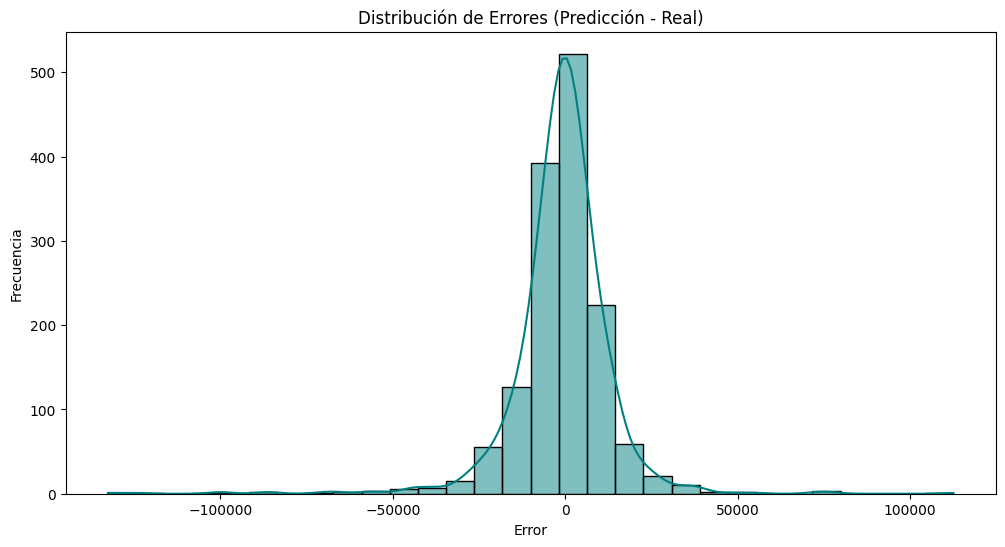

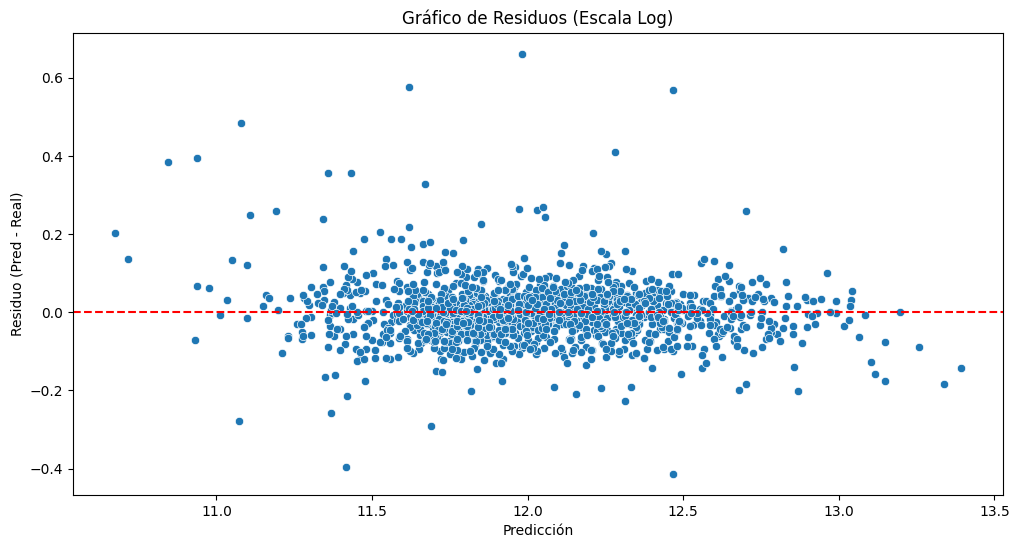

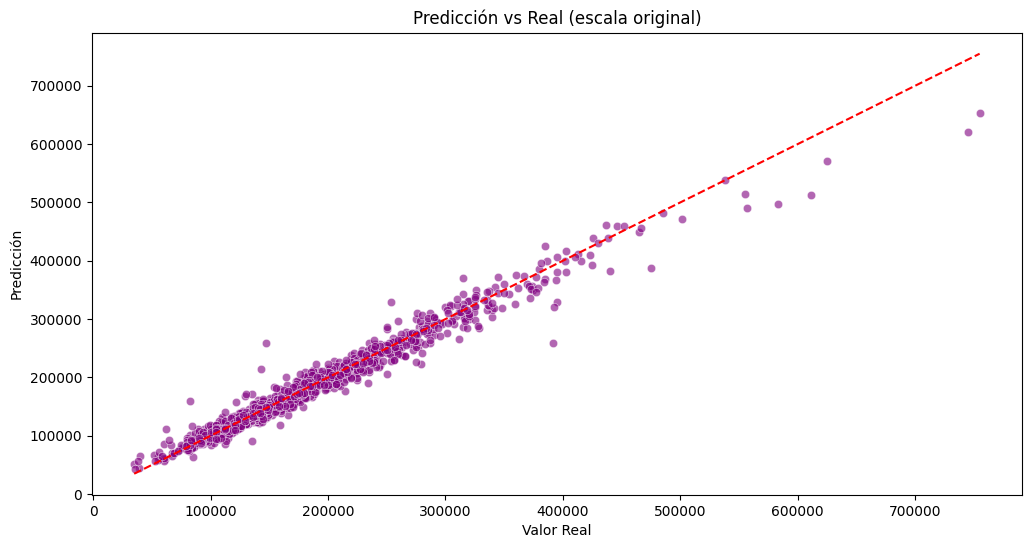

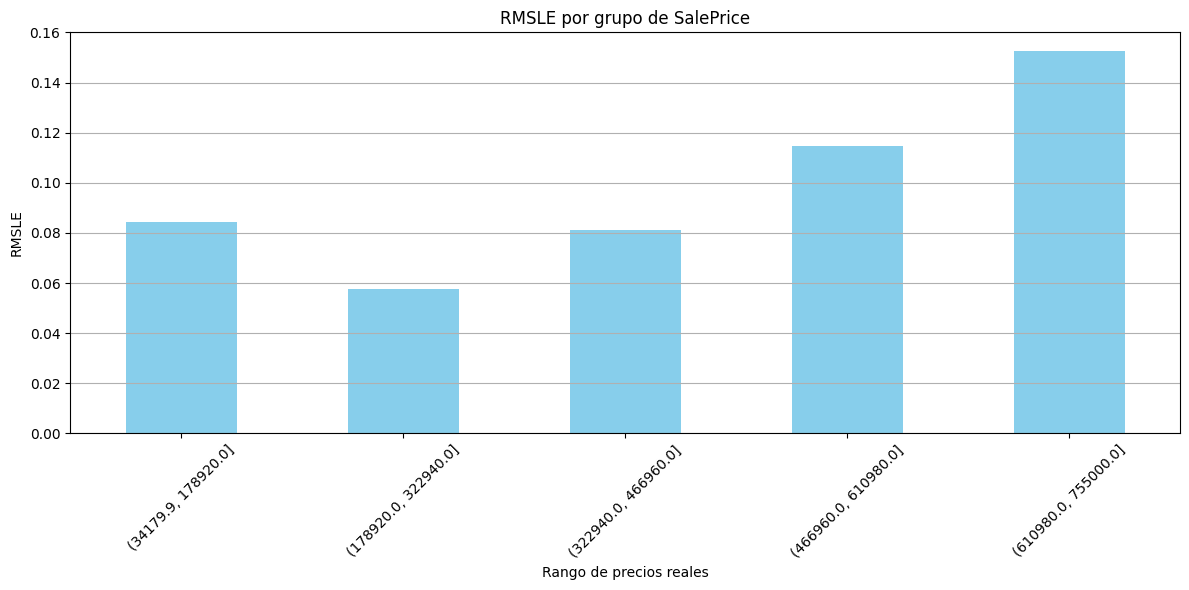

In [22]:
# Evaluación en datos de entrenamiento (log transformado)
final_train_pred = (stacked_train_pred * 0.4 +
                   xgb_train_pred * 0.3 +
                   lasso_train_pred * 0.2 +
                   gboost_train_pred * 0.1)

# Invertir log-transformación para interpretación real
y_train_real = np.expm1(y_train)
final_train_pred_real = np.expm1(final_train_pred)

# 1. Histograma de errores
errors = final_train_pred_real - y_train_real
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True, color='teal', bins=30)
plt.title('Distribución de Errores (Predicción - Real)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

# 2. Gráfico de residuos (log scale)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=final_train_pred, y=final_train_pred - y_train)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Residuos (Escala Log)')
plt.xlabel('Predicción')
plt.ylabel('Residuo (Pred - Real)')
plt.show()

# 3. Predicción vs Valor Real
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_train_real, y=final_train_pred_real, color='purple', alpha=0.6)
plt.plot([min(y_train_real), max(y_train_real)],
         [min(y_train_real), max(y_train_real)], '--r')
plt.title('Predicción vs Real (escala original)')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.show()

# 4. Error por rango de precios
y_bins = pd.cut(y_train_real, bins=5)
rmsle_per_bin = pd.Series(y_train_real).groupby(y_bins).apply(
    lambda g: np.sqrt(mean_squared_log_error(
        g, final_train_pred_real[g.index]))
)

plt.figure(figsize=(12, 6))
rmsle_per_bin.plot(kind='bar', color='skyblue')
plt.title('RMSLE por grupo de SalePrice')
plt.xlabel('Rango de precios reales')
plt.ylabel('RMSLE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Paso 10: Creación del Archivo

In [23]:
# Crear archivo de presentación
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(ensemble)
sub.to_csv('submission_proyecto1.csv', index=False)

print("¡Archivo de presentación creado con éxito!")

¡Archivo de presentación creado con éxito!
